In [1]:
import numpy
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
from matplotlib import pyplot as plot
from skgof import ad_test
%matplotlib inline

In [2]:
with open("4.txt") as file:
    data = numpy.array([float(line.split(',')[1]) for line in file])

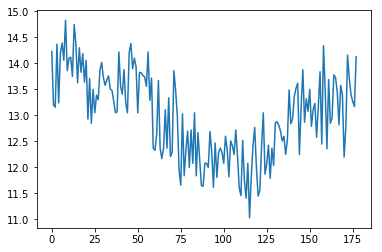

In [3]:
plot.plot(range(len(data)), data)

In [4]:
def vald_volfit_statistic(sample):
    mediana = numpy.percentile(sample, 50)
    n_0 = 0
    n_1 = 0
    N = 0
    state = None
    for value in sample:
        if value >= mediana:
            n_1 += 1
        else:
            n_0 += 1
        if state != (value >= mediana):
            N += 1
            state = (value >= mediana)
    
    return (
        (N - 1 - (2 * n_0 * n_1) / (n_0 + n_1)) / numpy.sqrt(
            (2 * n_0 * n_1 * (2 * n_0 * n_1 - n_0 - n_1)) / ((n_0 + n_1) ** 2 * (n_0 + n_1 - 1))
        )
    )

def inversion_statistic(sample):
    n = len(sample)
    I = 0
    for i in range(n):
        for j in range(i + 1, n):
            if sample[i] > sample[j]:
                I += 1
    E = n * (n - 1) / 4
    D = (2 * n ** 3 + 3 * n ** 2 - 5 * n) / 72
    return (I - E) / numpy.sqrt(D)

def vald_volfit_p_value(sample):
    statistic = vald_volfit_statistic(sample)
    if statistic < 0:
        return 2 * stats.norm.cdf(statistic)
    else:
        return 2 * stats.norm.sf(statistic)

def inversion_p_value(sample):
    statistic = inversion_statistic(sample)
    if statistic < 0:
        return 2 * stats.norm.cdf(statistic)
    else:
        return 2 * stats.norm.sf(statistic)

In [5]:
methods = [
    (lambda sample: inversion_p_value(sample)),
    (lambda sample: vald_volfit_p_value(sample)),
    (lambda sample: stats.shapiro(sample)[1]),
    (lambda sample: 
        stats.kstest(
            sample, lambda x: stats.norm.cdf(
                x, loc=stats.norm.fit(sample)[0],
                scale=stats.norm.fit(sample)[1]
            )
        )[1]
    ),
    (lambda sample: stats.jarque_bera(sample)[1]),
    (lambda sample:
        ad_test(
            sample, stats.norm(
                loc=stats.norm.fit(sample)[0],
                scale=stats.norm.fit(sample)[1]
            )
        )[1]
    ),
    (lambda sample: stats.skewtest(sample)[1])
]

methods_names = [
    "inversion",
    "Vald Volfit",
    "Shapiro",
    "SKtest",
    "Jarque Bera",
    "Anderson",
    "skewtest"
]

In [6]:
# Используем метод Холма
p_values = [method(data) for method in methods]
answers = multipletests(p_values, method="holm", alpha=0.05)[0]

In [7]:
for method_name, answer in zip(methods_names, answers):
    print("{}: {}".format(method_name, not answer))

inversion: False
Vald Volfit: False
Shapiro: True
SKtest: True
Jarque Bera: True
Anderson: True
skewtest: True


То, что данные выборка отвергается, а нрмальность принимается. Странно, но если случайным образом пошаблить данные, то все будет хорошо. Поэтому гипотезу нормальности можно принять.